In [1]:
from iminuit import Minuit
from iminuit.cost import ExtendedBinnedNLL
from scipy.stats import norm, expon
from scipy.interpolate import BPoly
import numpy as np
from pyik.mplext import plot_hist
import matplotlib.pyplot as plt

In [2]:
def scaled_cdf_bernstein(x, pars):
    pars = np.atleast_1d(pars)
    c = BPoly(pars[..., np.newaxis], xrange).antiderivative()
    return c(x)


def scaled_cdf_expon(x, a, b):
    return a * (1 - np.exp(-b * x))


def model1(x, a, b, c):
    sig = a * norm(0.5, 0.05).cdf(x)
    bkg = scaled_cdf_expon(x, b, c)
    return bkg + sig


def model2(x, par):
    sig = par[0] * norm(0.5, 0.05).cdf(x)
    bkg = scaled_cdf_bernstein(x, par[1:])
    return bkg + sig

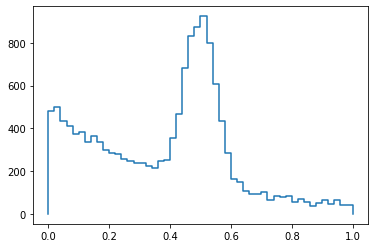

In [3]:
rng = np.random.default_rng(1)
xrange = np.array((0, 1))
x_bkg = rng.exponential(0.4, size=10000)
x_sig = norm(0.5, 0.05).rvs(5000)
x = np.append(x_bkg, x_sig)
x = x[(x > xrange[0]) & (x < xrange[1])]
n, xe = np.histogram(x, bins=50, range=xrange)
plot_hist(xe, n)

In [4]:
m1 = Minuit(ExtendedBinnedNLL(n, xe, model1), 500, 1000, 1)
m1.limits = (0, None)
m1.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 50.68                      │              Nfcn = 98               │
│ EDM = 4e-06 (Goal: 0.0002)       │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  5.01e3   │  0.08e3   │            │            │    0    │         │       │
│ 1 │ b    │  10.06e3  │  0.13e3   │            │            │    0    │         │       │
│ 2 │ c    │   2.46    │   0.04    │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────────┐
│   │         a         b         c │
├───┼───────────────────────────────┤
│ a │  7.23e+03 -3.09e+03     0.703 │
│ b │ -3.09e+03  1.68e+04     -2.61 │
│ c │     0.703     -2.61   0.00196 │
└───┴───────────────────────────────┘

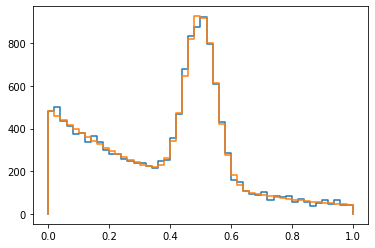

In [5]:
plot_hist(xe, n)
plot_hist(xe, np.diff(model1(xe, *m1.values)))

In [6]:
m2 = Minuit(ExtendedBinnedNLL(n, xe, model2), (500, 2e4, 2e3, 3e3))
m2.limits = (0, None)
m2.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 65.9                       │              Nfcn = 126              │
│ EDM = 1.1e-06 (Goal: 0.0002)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  4.95e3   │  0.09e3   │            │            │    0    │         │       │
│ 1 │ x1   │  23.0e3   │   0.4e3   │            │            │    0    │         │       │
│ 2 │ x2   │   2.2e3   │   0.5e3   │            │            │    0    │         │       │
│ 3 │ x3   │  2.54e3   │  0.19e3   │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────┐
│    │        x0        x1        x2        x3 │
├────┼─────────────────────────────────────────┤
│ x0 │  7.86e+03  1.98e+03 -1.41e+04  3.41e+03 │
│ x1 │  1.98e+03   1.4e+05 -1.02e+05  2.48e+04 │
│ x2 │ -1.41e+04 -1.02e+05  2.13e+05 -6.22e+04 │
│ x3 │  3.41e+03  2.48e+04 -6.22e+04  3.47e+04 │
└────┴─────────────────────────────────────────┘

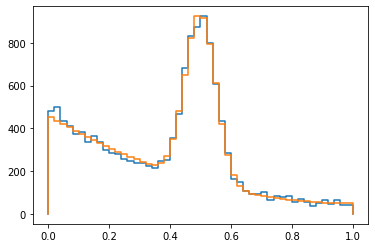

In [7]:
plot_hist(xe, n)
plot_hist(xe, np.diff(model2(xe, m2.values)))

In [8]:
m3 = Minuit(ExtendedBinnedNLL(n, xe, model2), (500, 1000, 1000, 1000, 1000))
m3.limits = (0, None)
m3.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 52.27                      │              Nfcn = 336              │
│ EDM = 7.46e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  5.03e3   │  0.09e3   │            │            │    0    │         │       │
│ 1 │ x1   │  24.5e3   │   0.6e3   │            │            │    0    │         │       │
│ 2 │ x2   │   5.8e3   │   0.9e3   │            │            │    0    │         │       │
│ 3 │ x3   │   4.3e3   │   0.6e3   │            │            │    0    │         │       │
│ 4 │ x4   │  2.07e3   │  0.21e3   │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4 │
├────┼───────────────────────────────────────────────────┤
│ x0 │   8.3e+03  1.06e+04  -2.7e+04  2.81e+03       558 │
│ x1 │  1.06e+04  3.16e+05 -3.97e+05  1.63e+05 -2.66e+04 │
│ x2 │  -2.7e+04 -3.97e+05  8.82e+05 -4.33e+05  7.95e+04 │
│ x3 │  2.81e+03  1.63e+05 -4.33e+05  3.68e+05 -9.17e+04 │
│ x4 │       558 -2.66e+04  7.95e+04 -9.17e+04  4.48e+04 │
└────┴───────────────────────────────────────────────────┘

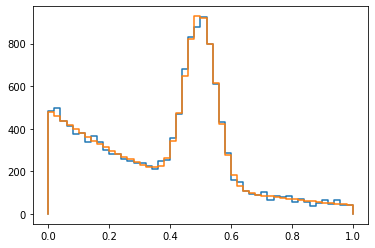

In [9]:
plot_hist(xe, n)
plot_hist(xe, np.diff(model2(xe, m3.values)))

In [62]:
m4 = Minuit(ExtendedBinnedNLL(n, xe, model2), (500, 1000, 1000, 1000, 1000, 1000))
m4.limits = (0, None)
m4.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 49.14                      │              Nfcn = 456              │
│ EDM = 7.25e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  4.97e3   │  0.10e3   │            │            │    0    │         │       │
│ 1 │ x1   │  25.2e3   │   0.7e3   │            │            │    0    │         │       │
│ 2 │ x2   │   8.0e3   │   1.5e3   │            │            │    0    │         │       │
│ 3 │ x3   │   8.6e3   │   2.0e3   │            │            │    0    │         │       │
│ 4 │ x4   │   2.1e3   │   1.0e3   │            │            │    0    │         │       │
│ 5 │ x5   │  2.38e3   │  0.29e3   │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5 │
├────┼─────────────────────────────────────────────────────────────┤
│ x0 │   9.6e+03 -4.21e+03   3.4e+04  -8.4e+04   3.7e+04 -5.97e+03 │
│ x1 │ -4.21e+03  4.94e+05 -8.14e+05     7e+05  -2.8e+05  4.65e+04 │
│ x2 │   3.4e+04 -8.14e+05  2.39e+06 -2.67e+06  1.17e+06 -2.02e+05 │
│ x3 │  -8.4e+04     7e+05 -2.67e+06  4.01e+06 -1.93e+06  3.54e+05 │
│ x4 │   3.7e+04  -2.8e+05  1.17e+06 -1.93e+06  1.11e+06 -2.39e+05 │
│ x5 │ -5.97e+03  4.65e+04 -2.02e+05  3.54e+05 -2.39e+05  8.19e+04 │
└────┴─────────────────────────────────────────────────────────────┘

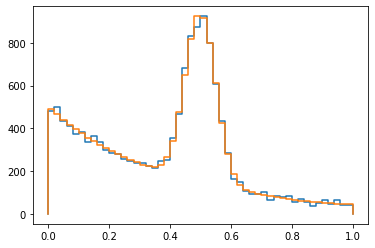

In [69]:
plot_hist(xe, n)
plot_hist(xe, np.diff(model2(xe, m4.values)))

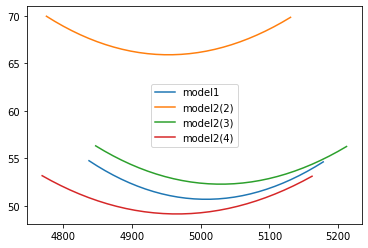

In [70]:
sig1, fcn1, _ = m1.mnprofile("a")
sig2, fcn2, _ = m2.mnprofile("x0")
sig3, fcn3, _ = m3.mnprofile("x0")
sig4, fcn4, _ = m4.mnprofile("x0")
plt.plot(sig1, fcn1, label="model1")
plt.plot(sig2, fcn2, label="model2(2)")
plt.plot(sig3, fcn3, label="model2(3)")
plt.plot(sig4, fcn4, label="model2(4)")
plt.legend()

In [77]:
sig, fcn1, ok = m1.mnprofile("a", size=50, bound=(4500, 5500))
assert np.all(ok)
_, fcn2, ok = m2.mnprofile("x0", size=50, bound=(4500, 5500))
assert np.all(ok)
_, fcn3, ok = m3.mnprofile("x0", size=50, bound=(4500, 5500))
assert np.all(ok)
_, fcn4, ok = m4.mnprofile("x0", size=50, bound=(4500, 5500))
assert np.all(ok)

In [89]:
def akaike(npar, n):
    return 2 * npar / (1 - (npar + 1) / n)

def simple(npar, n):
    return npar

In [82]:
fcn_min = np.inf
for fcn, npar in ((fcn1, m1.nfit), (fcn2, m2.nfit), (fcn3, m3.nfit), (fcn4, m4.nfit)):
    fcn_min = np.minimum(fcn_min, fcn + akaike(npar, len(n)))

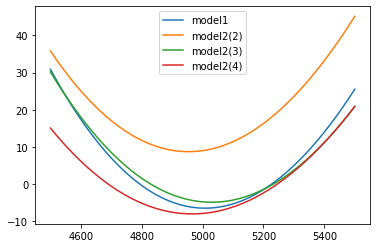

In [85]:
plt.plot(sig, fcn1-offset, label="model1")
plt.plot(sig, fcn2-offset, label="model2(2)")
plt.plot(sig, fcn3-offset, label="model2(3)")
plt.plot(sig, fcn4-offset, label="model2(4)")
plt.legend()

(0.0, 20.0)

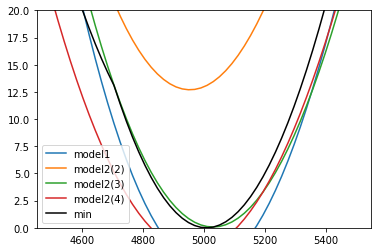

In [90]:
offset = np.min(fcn_min)

plt.plot(sig, fcn1-offset+simple(m1.nfit, len(n)), label="model1")
plt.plot(sig, fcn2-offset+simple(m2.nfit, len(n)), label="model2(2)")
plt.plot(sig, fcn3-offset+simple(m3.nfit, len(n)), label="model2(3)")
plt.plot(sig, fcn4-offset+simple(m4.nfit, len(n)), label="model2(4)")
plt.plot(sig, fcn_min-offset, color="k", label="min")
plt.legend()
plt.ylim(0, 20)